In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import time
import copy

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import data_utils, stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 10
subjects = np.arange(1,11)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')

# this is the original analysis that I ran with 7 subjects, exactly as in first submission
save_filename1 = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
print(save_filename1)
print(time.ctime(os.path.getmtime(save_filename1)))
d1 = np.load(save_filename1, allow_pickle=True).item()

# this is the newest 3 subjects, for revision
save_filename2 = os.path.join(save_folder, 'decode_multiclass_withintask_newsubs.npy')
print(save_filename2)
print(time.ctime(os.path.getmtime(save_filename2)))
d2 = np.load(save_filename2, allow_pickle=True).item()
d2.keys()

# we're going to concatenate everything from these saved dictionaries
dec = dict([])
for kk in list(d1.keys()):
    
    if kk in ['preds_all', 'probs_all']:
        # this element is a dictionary where keys are subjects
        dec[kk] = d1[kk]
        for si in d2[kk].keys():
            # entry 0 in the new array becomes 7 in new array
            dec[kk][si+7] = d2[kk][si]
        
    elif kk in ['grid_pts', 'roi_names']:
        dec[kk] = d1[kk]
        
    else:
        dec[kk] = np.concatenate([d1[kk], d2[kk]], axis=0)
      
    
roi_names = dec['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)
roi_names

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask.npy
Fri Jun  2 12:40:24 2023
/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask_newsubs.npy
Tue Aug 13 08:41:26 2024


['V1', 'V2', 'V3', 'V3AB', 'hV4', 'LO1', 'LO2', 'IPS']

#### compute confusion matrices for 16-way classifier

In [6]:
n_pts = grid_pts.shape[0]

grid_confusion = np.zeros((n_subjects, n_rois, n_tasks, n_pts, n_pts), dtype=int)

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T.round(2)
        # nn_pts = np.array([l['nn_ptx'], l['nn_pty']]).T.round(2)
        
        pt_inds = np.zeros((pt_labs.shape[0],), dtype=int)
        for tr in range(pt_labs.shape[0]):
            ind = np.argmin(np.sum((pt_labs[tr,:]-grid_pts)**2, axis=1))
            pt_inds[tr] = ind
            
        
        is_main_grid = l['is_main_grid']==1
       
        correct = np.array(l['subject_correct'])
        
        
        for ri in range(n_rois):
            
            pred = dec['preds_all'][si][ri][ti].astype(int)
            
            for pi1 in range(n_pts):

                for pi2 in range(n_pts):
                    
                    inds = (pt_inds==pi1) & (pred==pi2) & is_main_grid & correct

                    grid_confusion[si,ri,ti,pi1,pi2] = np.sum(inds)
                    
                    
# convert the counts into a proportion
# out of the total trials with actual grid position pi1, how often was it assigned to pi2?
# the last dim should sum to 1.
counts_each = np.sum(grid_confusion, axis=4, keepdims=True)
prop_confusion = grid_confusion / np.tile(counts_each, [1,1,1,1,n_pts])

# nans are from zero denominator, turn these to 0 here
# these only affect checker task, not either of two linear tasks
assert(not np.any(np.isnan(prop_confusion[:,:,0:2,:,:])))
prop_confusion[np.isnan(prop_confusion)] = 0

/usr/local/serenceslab/maggie/conda_envs/shape_dim/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


In [7]:
np.sum(counts_each[:,:,2,:,0]==0, axis=2)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [8]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

#### create templates

In [9]:
template_names = ['Linear 1','Linear 2','Checker']
n_templates = 3;

ideal_conf_matrices = np.zeros((n_pts, n_pts, n_templates))


for gg1 in range(n_pts):
    
    for gg2 in range(n_pts):
        
        pt1 = grid_pts[gg1:gg1+1,:]
        pt2 = grid_pts[gg2:gg2+1,:]
        
        
        if grid_utils.get_categ(pt1, 1)==grid_utils.get_categ(pt2, 1):
            ideal_conf_matrices[gg1,gg2,0] = 1
        
        if grid_utils.get_categ(pt1, 2)==grid_utils.get_categ(pt2, 2):
            ideal_conf_matrices[gg1,gg2,1] = 1
        
        if grid_utils.get_categ(pt1, 3)==grid_utils.get_categ(pt2, 3):
            ideal_conf_matrices[gg1,gg2,2] = 1
        

Text(0.5, 1.0, 'Checker')

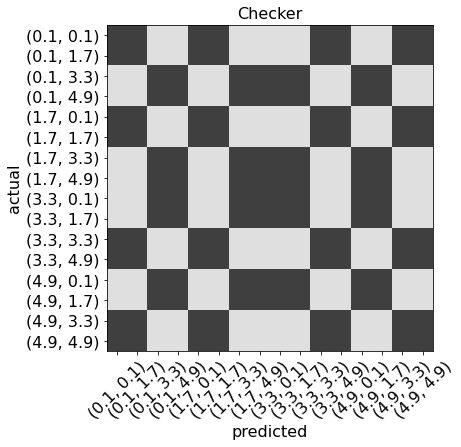

In [10]:
plt.figure(figsize=(6,6))

ti = 2;
    
grid_pt_strs = np.array(['(%.1f, %.1f)'%(grid_pts[ii,0], grid_pts[ii,1]) for ii in range(len(grid_pts))])


plt.pcolormesh(ideal_conf_matrices[:,:,ti], vmin=-0.2, vmax=1.4, cmap='gray_r')
plt.axis('square')
plt.gca().invert_yaxis()


plt.xticks(np.arange(n_pts)+0.5, grid_pt_strs, rotation=45)
plt.xlabel('predicted')

plt.yticks(np.arange(n_pts)+0.5, grid_pt_strs)

plt.ylabel('actual')


plt.title('%s'%template_names[ti])

# figname = os.path.join(figfolder, 'checker_task_template.pdf')
# plt.savefig(figname)

#### compare actual confusions to templates

In [11]:
sim_each = np.zeros((n_subjects, n_rois, n_tasks, n_templates))
sim_each_z = np.zeros((n_subjects, n_rois, n_tasks, n_templates))

for si in range(n_subjects):

    for ri in range(n_rois):

        for ti in range(4):

            props = prop_confusion[si,ri,ti,:,:]
    
            for tmpi in range(n_templates):

                template = ideal_conf_matrices[:,:,tmpi]

                r = np.corrcoef(props.ravel(), template.ravel())[0,1]
                
                sim_each[si,ri,ti,tmpi] = r
                
                # z-transforming the r values here.
                # use the Fisher transform (inverse hyperbolic tangent)
                # https://en.wikipedia.org/wiki/Fisher_transformation
                
                sim_each_z[si,ri,ti,tmpi] = np.arctanh(r)
                

#### plot similarity to checker template

-0.08677079871354215 0.32118217073414557
-0.046525441391508986 0.34568256566335165
-0.10549868681987701 0.35648673881593995
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/checker_confusion_template_sim.pdf


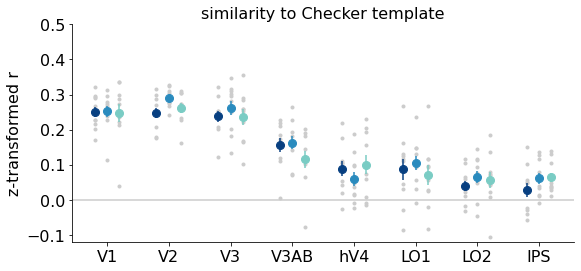

In [12]:
plt.figure(figsize=(9,4))

ax = plt.subplot(1,1,1)
ti_plot = [0,1,2]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi in [2]:
    
    tmpname = template_names[tmpi]
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        # vals = sim_each[:,:,ti,tmpi]
        vals = sim_each_z[:,:,ti,tmpi]
        print(np.min(vals), np.max(vals))
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], markersize=8, zorder=10)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(sim_each_z[:,ri,ti_plot,tmpi], axis=0)
        # plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6], zorder=-5)

        plt.plot(ri+x_jitter, sim_each_z[:,ri,ti_plot,tmpi].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)

    ylims = [-0.12, 0.5]
    assert(np.all(sim_each_z[:,:,ti_plot,tmpi]>ylims[0]))
    assert(np.all(sim_each_z[:,:,ti_plot,tmpi]<ylims[1]))
    plt.ylim(ylims)

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('z-transformed r')

    # plt.legend(lh,task_names)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.yticks(np.arange(-0.1, 0.51, 0.1))
        
    # plt.legend(lh,task_names)

    plt.title('similarity to %s template'%tmpname)
    
figname = os.path.join(figfolder, 'checker_confusion_template_sim.pdf')
print(figname)

plt.savefig(figname)

In [17]:
ti_test = [0,1,2]
tmpi_test = [2]

for tmpi in tmpi_test:
    
    # vals = copy.deepcopy(sim_each[:,:,ti_test,tmpi])
    vals = copy.deepcopy(sim_each_z[:,:,ti_test,tmpi])

    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], \
                                            do_shuffle=True, n_iter=10000, rndseed = 1242335+tmpi)
    # anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], \
    #                                         do_shuffle=False, n_iter=10000, rndseed = 1242335+tmpi)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    # print('\nAnova for template similarity, %s'%template_names[tmpi])
    # print(anova_result)
    
    tablename = os.path.join(figfolder, 'template_sim_includechecker_rm_anova_2way_template%d.csv'%(tmpi+1))

    print(tablename)
    anova_result.to_csv(tablename)


/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_includechecker_rm_anova_2way_template3.csv


In [13]:
for tmpi in [2]:
    tablename = os.path.join(figfolder, 'template_sim_includechecker_rm_anova_2way_template%d.csv'%(tmpi+1))
    print('\nAnova for template similarity, %s'%template_names[tmpi])
    anova_result = pd.read_csv(tablename, index_col=0)
    print(tablename)
    print(time.ctime(os.path.getmtime(tablename)))
    
    print(anova_result)


Anova for template similarity, Checker
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/template_sim_includechecker_rm_anova_2way_template3.csv
Thu Dec 12 12:17:24 2024
            F Value  Num DF  Den DF  Pr > F  p (permutation)
roi       63.196602     7.0    63.0  0.0000           0.0000
task       1.191598     2.0    18.0  0.3266           0.3290
roi:task   1.286205    14.0   126.0  0.2249           0.2216
